# **Imports**

Below are all the imports used in the **Notebook**.

In [1]:
# Common
import os 
import keras
import numpy as np 
import tensorflow as tf

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

# **Data Info**

Before **loading the data**, let's have a look at the **class distribution**.

In [2]:
# Class Names
root_path = '../input/vegetable-image-dataset/Vegetable Images/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]


# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 15 
Class Names : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


Let's loot at the **Class Distribution**.

In [3]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

**Great!!** all the classes are **equally distributed**. This ensures that our **model cannot be biased** towards any class.

# **Data Loading**

It's time to **load the data**.

In [4]:
# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255.)

# Load Data
train_ds = train_gen.flow_from_directory(root_path, class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
valid_ds = valid_gen.flow_from_directory(root_path.replace('train','validation'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)
test_ds = test_gen.flow_from_directory(root_path.replace('train', 'test'), class_mode='binary', target_size=(256,256), shuffle=True, batch_size=32)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


# **Data Visualization**

The best way to understand the data is to **visualize it**.

In [5]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

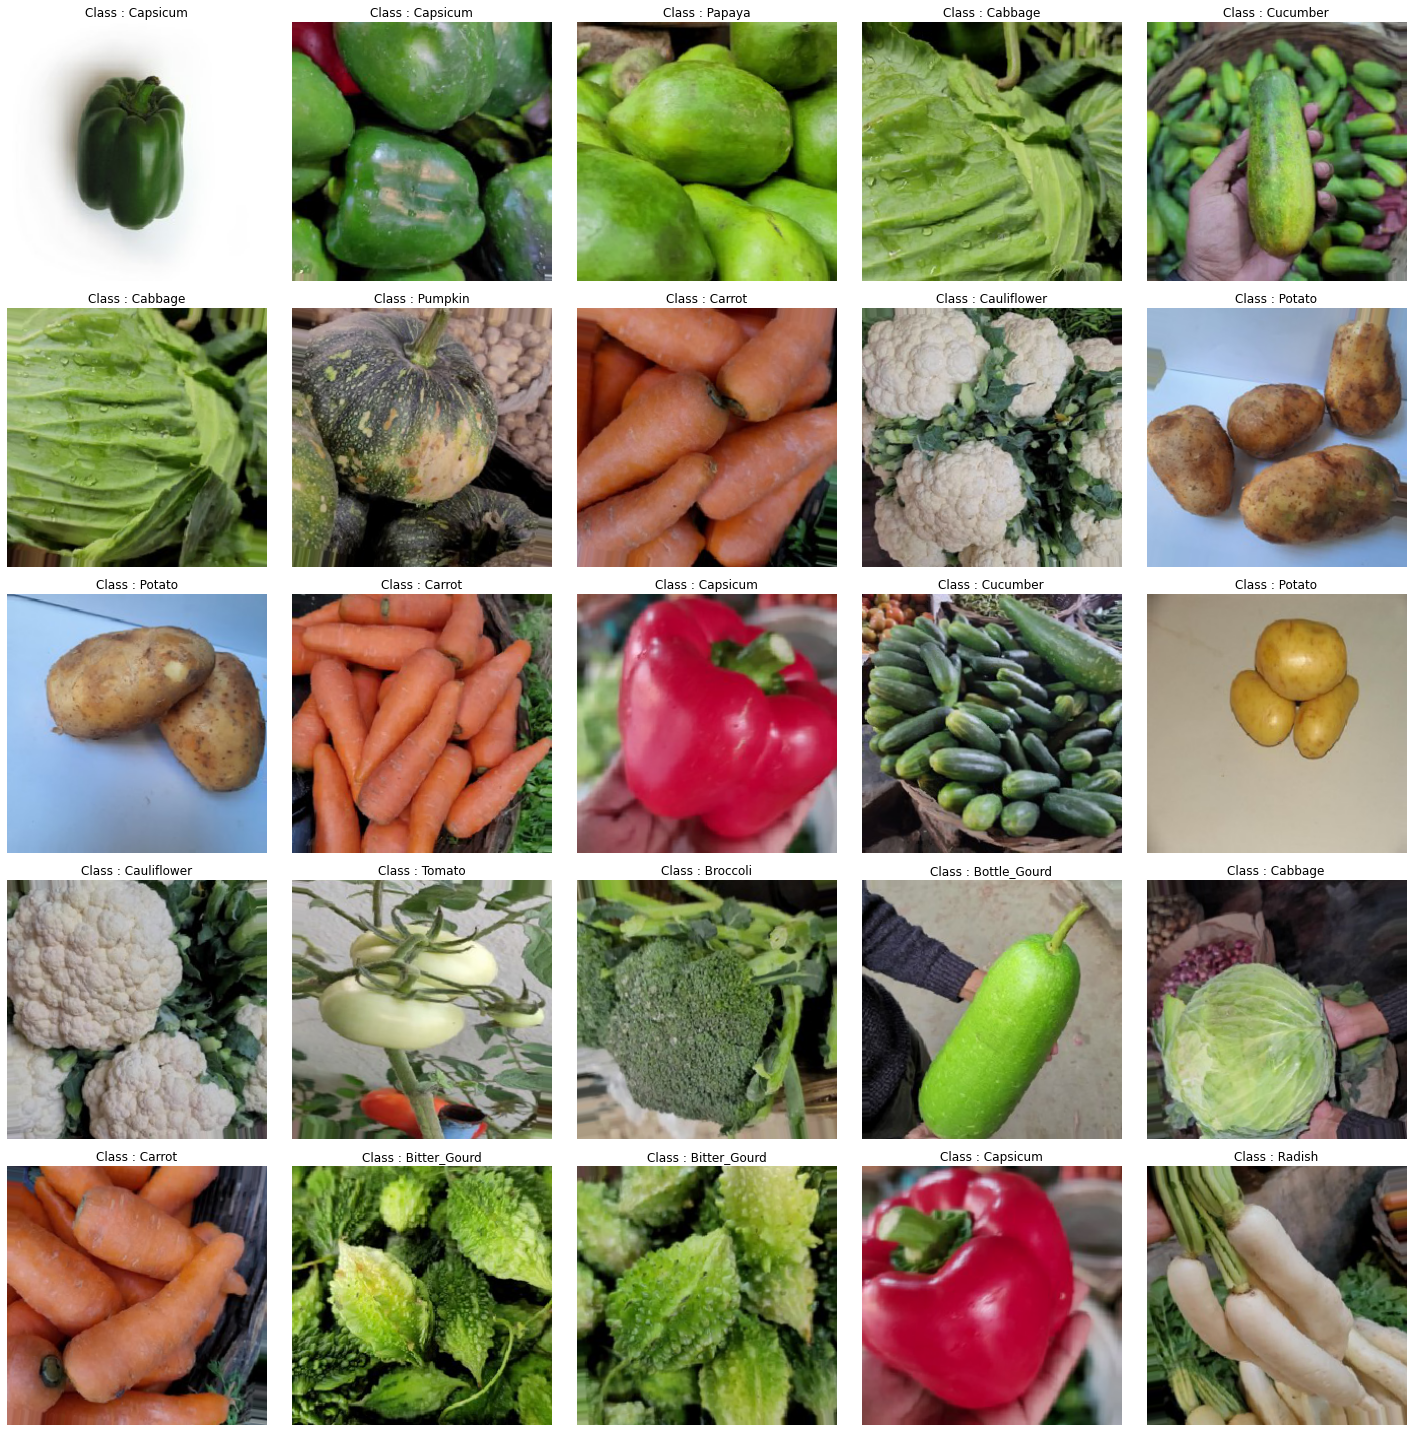

In [6]:
show_images()

This is going to be an **Interesting Task**. Let's see how **Transfer Learning** will perform.

# **Model**

In [7]:
# Pre-Trained Model 
base_model = ResNet50V2(input_shape=(256,256,3), include_top=False)
base_model.trainable = False

# Model Architecture
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax')
], name=name)

# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Model Compiling
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model Training
# model.fit(train_ds, validation_data=valid_ds, callbacks=cbs, epochs=50)

2022-10-21 01:39:38.020065: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94683136/94668760 [==============================] - 1s 0us/step


The model **achieved 99% Accuracy** on **both datasets** in the **2nd Epoch** itself, which is **awesome**. The model converged at the **6th Epoch**, the **loss** was **0.003** and **accuracy** was **99.83%**. after that it started **over fitting the data**.

# **Evaluation**

In [8]:
# Specify Model Path
model_path = '../input/vegetable-classifier-acc-9987/ResNet50V2- Vegetable-Classifier.h5'
model = load_model(model_path)

# Architecture
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3855      
Total params: 24,093,199
Trainable params: 528,399
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
# Evaluation on test Set
model.evaluate(test_ds)

2022-10-21 01:39:44.543047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


94/94 [==============================] - 240s 3s/step - loss: 0.0290 - accuracy: 0.9910


[0.02896341122686863, 0.9909999966621399]

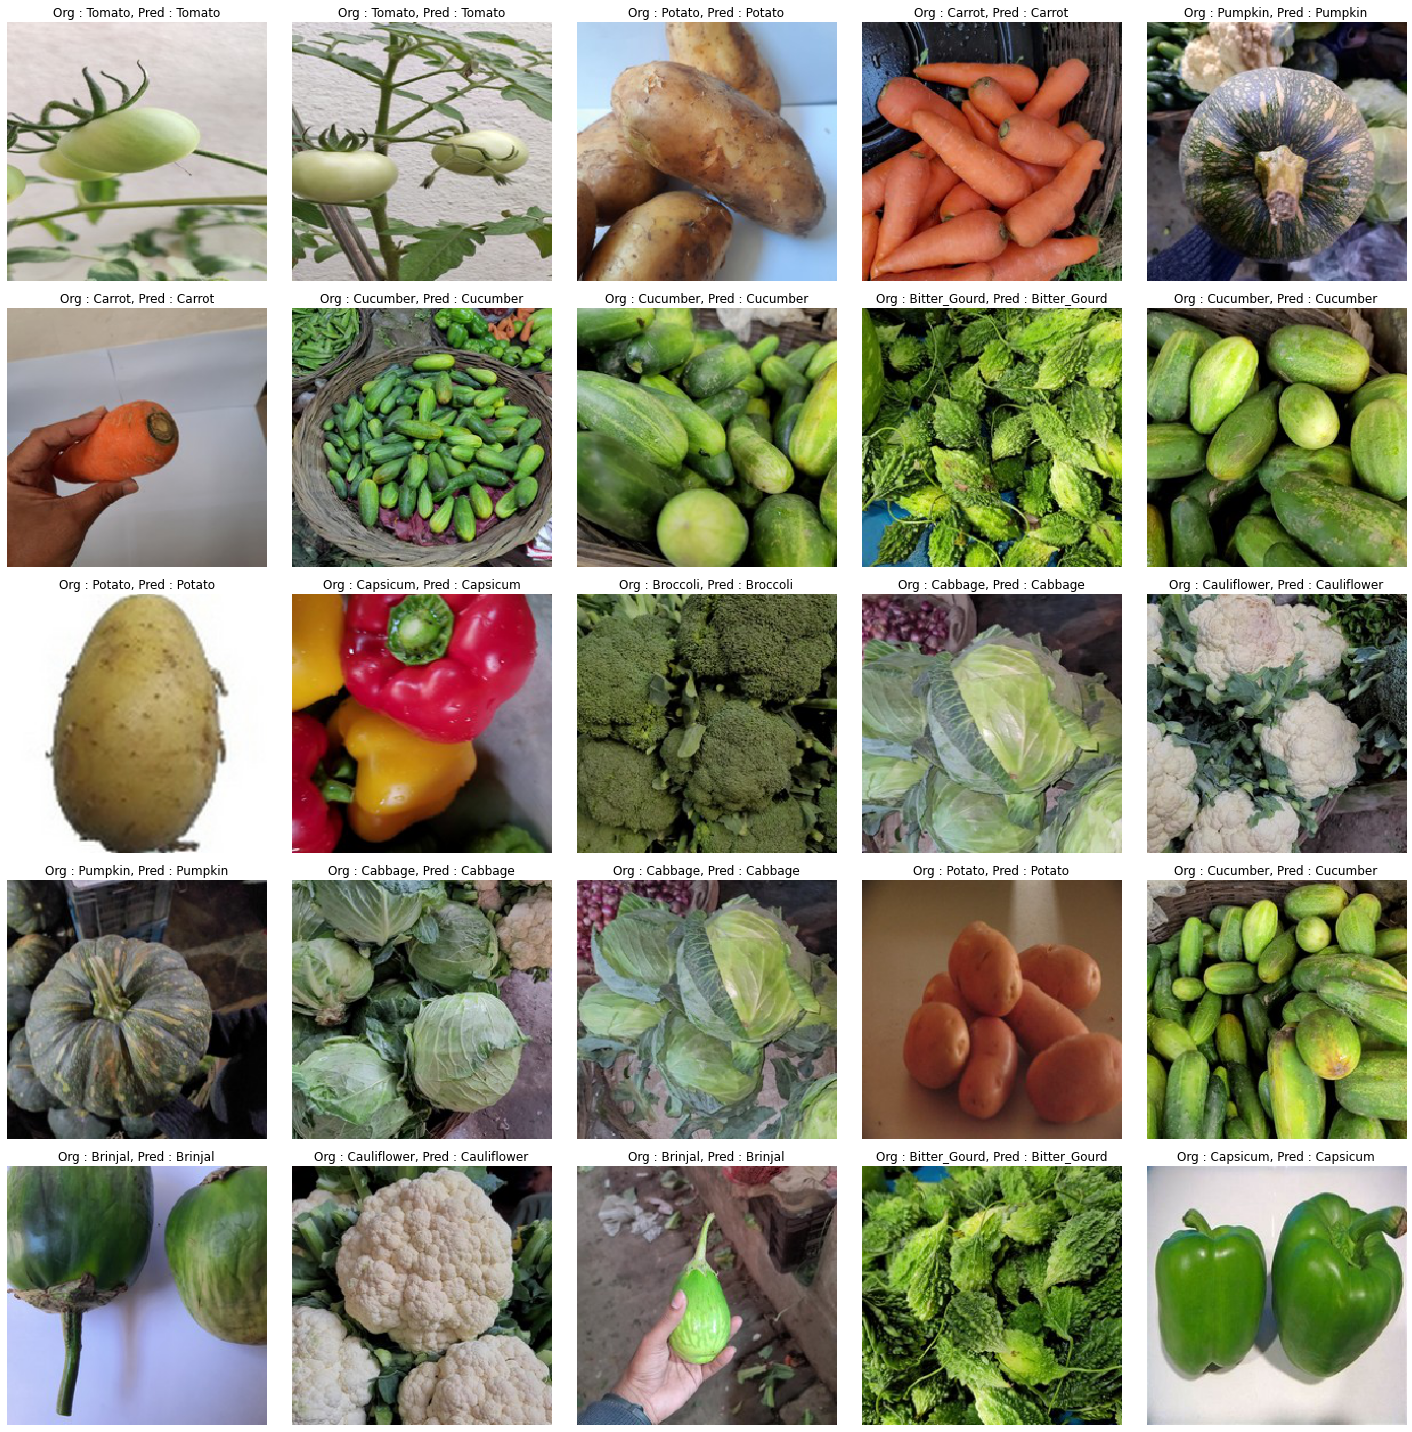

In [10]:
# Visualize Predictions
show_images(model=model, data=test_ds)

All the **predictions are correct** as the model has **99% accuracy** on **training, testing and validation data set** it seems to be **very promising**. You can try the model.

**Thank You, Let me know your suggestions in the comment box.**

---
**DeepNets**